### Example using pruning for channel selection

Prior to running this, make sure you have the [NLB MC_RTT dataset](https://dandiarchive.org/dandiset/000129) downloaded and select the file path in the `nlb_data_path` variable below.

Takes about 10min to run on an M1 CPU.

In [1]:
import torch
import torch.nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sparsebmi.utils as utils
import sparsebmi.models as models
import sparsebmi.config as config
import sparsebmi.training as training
import sparsebmi.channelselect as channelselect
import sparsebmi.data_loading as data_loading

%load_ext autoreload
%autoreload 2

device = utils.get_torch_device()
print(f"Using device: {device}")

Using device: cpu


Configuration options

In [ ]:
nlb_data_path = '.../000129/sub-Indy' # your path here

model_type = 'lstm'      # (this should always be lstm for now)

# which percent channels to prune
prune_fracs = [0, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]

verbose_train = False

Load data, create model, train, prune, and test

In [3]:
# get config
if model_type == 'lstm':
    cfg = config.Config().add_config([config.default_cfg_data, config.cfg_lstm_nlb]) 
else:
    raise ValueError("Invalid model type")

loss_fn = torch.nn.MSELoss()

# load data
num_inputs = 130
num_outputs = 4
loader_train, loader_val, loader_test = data_loading.load_nlb(
    nlb_dataset_path=nlb_data_path,
    binsize_ms=cfg.binsize_ms,
    seq_len=cfg.hist_bins,
    batch_size=cfg.batch_size,
    train_val_test=cfg.train_val_test_split,
    pred_type=cfg.pred_type,
    normalize_x=cfg.normalize_x,
    normalize_y=cfg.normalize_y
)

Train: (14193, 130) (14193, 4)
Val: (2027, 130) (2027, 4)
Test: (4056, 130) (4056, 4)


In [5]:
resultsdflist = []


for prune_frac in prune_fracs:
    print(f'\nDropping {prune_frac*100}% iteratively...\n')    

    # create model
    if model_type == 'tcn':
        model = models.TCN(num_inputs, cfg.hist_bins, cfg.conv_num_filts, cfg.layer_size_list, num_outputs, cfg.dropout_p)
    elif model_type == 'lstm':
        model = models.RNN(num_inputs, cfg.hidden_size, num_outputs, cfg.num_layers, 
                            rnn_type='lstm', drop_prob=cfg.dropout_p, dropout_input=0, device=device)
    elif model_type == 'rnn':
        model = models.RNN(num_inputs, cfg.hidden_size, num_outputs, cfg.num_layers, 
                            rnn_type='rnn', drop_prob=cfg.dropout_p, dropout_input=0, device=device)
    model.to(device=device)

    # wrap model with a channel selection layer
    model = channelselect.ChannelSelectWrapper(model, num_inputs).to(device)

    # set up optimizer
    optimizer = optim.Adam(model.parameters(), lr=cfg.start_lr, weight_decay=cfg.weight_decay)
    lr_scheduler = utils.LinearLRScheduler(optimizer, start_lr=cfg.start_lr, end_lr=cfg.end_lr, num_steps=cfg.num_iters)
    if int(prune_frac*num_inputs) > 0:
        prune_scheduler = utils.LinearScheduler(0, prune_frac, cfg.iters_before_drop, cfg.iters_to_max_drop)
    else:
        prune_scheduler = None

    # train & drop channels
    _, corrs, mses, _ = training.train_chanselect_model(model, loader_train, loader_val, optimizer, lr_scheduler, 
                                                cfg.num_iters, model.compute_loss, check_every=cfg.check_every, verbose=verbose_train, 
                                                is_rnn=cfg.is_rnn, prune_scheduler=prune_scheduler, device=device)

    # get test performance
    model.eval().to(device)
    test_corr, test_mse = training.eval_model(model, loader_test, device=device)
    y, yhat = training.run_model_forward(model, loader_test, device=device)

    # get test performance
    model.eval()
    test_corr, test_mse = training.eval_model(model, loader_test, device=device)
    print(f'Test corr: {test_corr}, Test MSE: {test_mse}')

    # save
    num_dropped = model.get_num_dropped_chans()
    drop_frac = num_dropped / num_inputs
    thisresult = {
        'num_dropped': [num_dropped],
        'actual_drop_frac': [drop_frac],
        'desired_drop_frac': [prune_frac],
        'num_active_chans': [num_inputs - num_dropped],
        'corr': [test_corr],
        'avgcorr': [np.mean(test_corr)],
        'mse': [test_mse],
        'model_type': [model_type],
    }
    resultsdflist.append(pd.DataFrame(thisresult))

resultsdf = pd.concat(resultsdflist)


Dropping 0% iteratively...

Test corr: [0.80026903 0.86921886 0.88480501 0.87419533], Test MSE: 0.28069302439689636

Dropping 25.0% iteratively...

Test corr: [0.81091163 0.86537457 0.88519137 0.87221517], Test MSE: 0.286040335893631

Dropping 50.0% iteratively...

Test corr: [0.80119064 0.83944504 0.88154763 0.86534161], Test MSE: 0.3289065361022949

Dropping 60.0% iteratively...

Test corr: [0.79161688 0.83963927 0.862131   0.85971259], Test MSE: 0.32486629486083984

Dropping 70.0% iteratively...

Test corr: [0.78267835 0.82039316 0.87353817 0.8476645 ], Test MSE: 0.32427674531936646

Dropping 80.0% iteratively...

Test corr: [0.73721088 0.76685482 0.8157864  0.83716769], Test MSE: 0.39838331937789917

Dropping 90.0% iteratively...

Test corr: [0.6271943  0.70702219 0.75324516 0.77699451], Test MSE: 0.5288600921630859

Dropping 95.0% iteratively...

Test corr: [0.5670664  0.62515503 0.69569843 0.57542957], Test MSE: 0.7051784992218018

Dropping 98.0% iteratively...

Test corr: [0.46

Plot MSE vs number of parameters

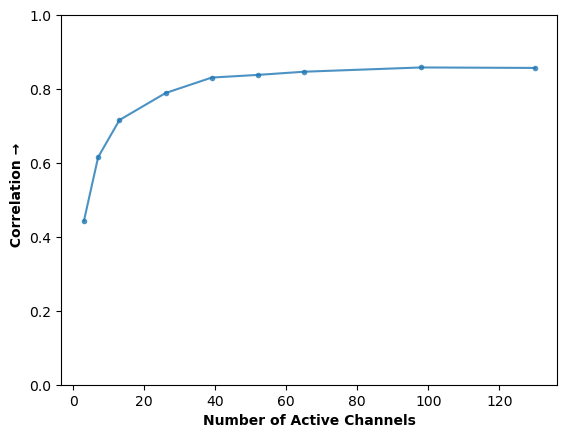

In [7]:

errbar = 'se'
kwargs = {'alpha': 0.8, 'marker': 'o', 'markersize': 4, 'linewidth': 1.5, 'markeredgewidth': 0}

xvar = 'num_active_chans'
yvar = 'avgcorr'

sns.lineplot(data=resultsdf, x=xvar, y=yvar, errorbar=errbar, **kwargs)

# plt.xscale('log')
plt.ylim([0, 1.0])
plt.ylabel('  Correlation →', fontweight='bold')
plt.xlabel('Number of Active Channels', fontweight='bold')
plt.show()